# DT2119 - Speech and Speaker Recognition - Lab 2:  Hidden Markov Models with Gaussian Emissions

## 1. Introduction
### 1.1. Data set

The dataset used in this lab is similar to the one used in the previous labs: 44 spoken utterance from one male and one female from the tidigits database. . For each speaker, 22 speech files are included containing two repetitions of isolated digits (eleven words: “oh”, “zero”, “one”, “two”, “three”, “four”, “five”, “six”, “seven”, “eight”, “nine”).
    
## 2. Implementation

The next sections will show how the implementation in python was done, plotting the main results and explaining the main conclusion that were drawn from the experimentation. 
    
### 2.1 Loading the data

The first step is to download the dataset that will be used in the lab and prepare the workspace

In [1]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import sklearn.mixture as skm
import proto
import tools2
import warnings
warnings.filterwarnings('ignore')

tidigits = np.load('lab2_tidigits.npz', encoding='latin1' )['tidigits']

#### The models

Additionally, the lab2_models.npz file contains the parameters of the models we are going to use to test our functions. The models array has length 11 each element corresponding to one of the following digits ['o','z','1','2','3','4','5','6','7','8','9']. Each element contains the following keys:

In [2]:
models = np.load('lab2_models.npz', encoding='latin1')['models']
models[0].keys()

dict_keys(['pron', 'digit', 'gmm', 'hmm'])

   1. Digit: the digit the model refers to
   2. Pron: pronunciation of the digit in terms of phonemes (not needed in this exercise)
   3. hmm: model parameters of a Gaussian HMM trained with Baum-Welch
   4. gmm: model parameters of a GMM trained with EM
    
Both the HMMs and the GMMs were trained on the same data (different from the data in
the tidigits array) and were initialized the same way. Both use diagonal covariance matrices
for the Gaussian distributions. The size of the model (number of states in HMM and number of
Gaussians in GMM) depends on the digit and was obtained using three states for each phoneme
in models[i]['pron'] plus three states for the initial and final silence in the utterance. 

### 2.2 HMM models. Transition matrix and start probability. 

#### Transition matrtix
We want to analyze the main characteristics of the models. Lets study first the transition matrix of the proposed HMM models. To do so, we are going to plot the transition matrix of 3 of the digit's HMM models: 

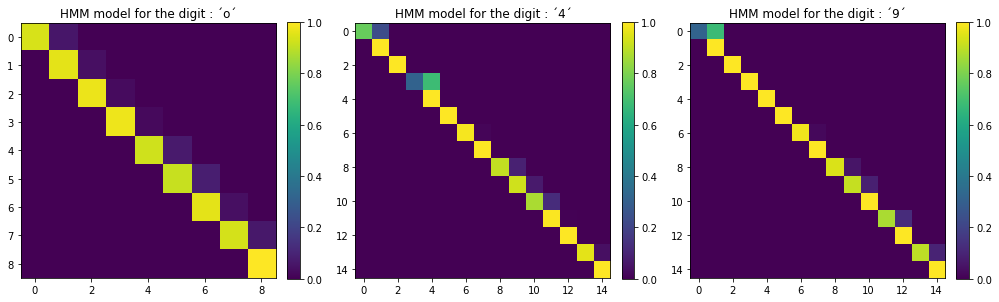

In [3]:
%matplotlib inline
# New figure
plt.figure(figsize=(17,17))

# Generate subplots and show the matrices.
plt.subplot(131)
plt.imshow(models[0]['hmm']['transmat'], interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('HMM model for the digit : ´%s´'%(models[0]['digit']))
plt.subplot(132)
plt.imshow(models[5]['hmm']['transmat'], interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('HMM model for the digit : ´%s´'%(models[5]['digit']))
plt.subplot(133)
plt.imshow(models[10]['hmm']['transmat'], interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('HMM model for the digit : ´%s´'%(models[10]['digit']))

We can observe that the transition matrices of the HMM models are mainly diagonal.This means that the model has most of the chance to stay in the same state. Some coefficients after the diagonal are different from 0, this means that there is a small possibility of moving to the next state. The rest of the posibilities are 0. We are using the first Markov assumption then.

#### Initial probability

Now we are going to study the initial probability distribution of the HMM model. If we print some of the digits modeled by HMM, we have that the initial probabilities are: 


In [4]:
models[0]['hmm']['startprob']

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [5]:
models[5]['hmm']['startprob']

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.])

We can observe that the first state has one probability, being probabilities of the rest of states 0. This makes sense as the model can not go to a previous state, and has to pass over all the states.

### 2.3 Multivariate Gaussian Density

We are going to study now the results of applying the log_multivariate_normal_density function on the GMM and HMM models. This function represents the following probabilistic expression: 

   $logemlik[i,j] = log\phi_j(x_i) = log N(x_i,\mu_j,Σ_j) = logP(x_i|\mu_j,Σ_j)$
    
that is the log likelihood for each observation $x_i$ and each term in a multivariate Gaussian density
function with means $µ_j$ and diagonal cov matrices $Σ_j$. In the case of Gaussian HMMs,
$\phi_j$ corresponds to the emission probability model for a single state $j$. In case of a GMM, $\phi_j$ 
corresponds to a single Gaussian in the model, without considering the weights.

The first step is to load the example data set, that we are going to use to compare and check if we know how to properly use this function. 

In [6]:
example = np.load('lab2_example.npz', encoding='latin1')['example'].item()

The first step is to verify that you get the same results as in example['hmm_obsloglik'] and example['gmm_obsloglik'] when you apply the log_multivariate_normal_density function to the example['mfcc'] data using the Gaussian distributions defined respectively in models[0]['hmm'] and models[0]['gmm']. 

We first apply the log_multivariate_normal_density function to the example['mfcc'] for both HMM and GMM models: 

In [7]:
# Log likelihood fot GMM model
gmm_obsloglik = skm.log_multivariate_normal_density(example['mfcc'],models[0]['gmm']['means'],models[0]['gmm']['covars'], 'diag')

# Log likelihoof for HMM model
hmm_obsloglik = skm.log_multivariate_normal_density(example['mfcc'],models[0]['hmm']['means'],models[0]['hmm']['covars'], 'diag')

We compare first the output when the GMM model is applyied to the already calculated log likelihood in the example data set: 

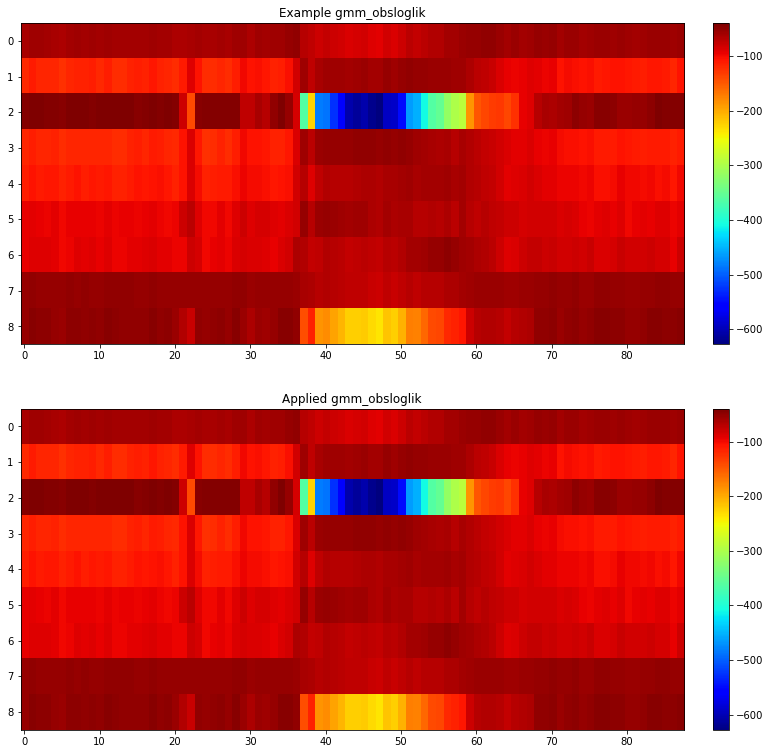

In [8]:
%matplotlib inline

# New figure
plt.figure(figsize=(13,13))

# Generate subplots and show the matrices.
plt.subplot(211)
plt.imshow(example['gmm_obsloglik'].transpose(),interpolation='nearest', aspect='auto', cmap = plt.cm.get_cmap('jet'))
plt.colorbar(fraction=0.046, pad=0.04)

plt.title('Example gmm_obsloglik')
plt.subplot(212)
plt.imshow(gmm_obsloglik.transpose(), interpolation='nearest',aspect='auto', cmap = plt.cm.get_cmap('jet'))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Applied gmm_obsloglik')

We can see that the result is identical. We can also see that while in the right and left sides of the image we have very high likelihoods, in the middle part we have some areas with very low likelihood. In the 2nd state the likelihood with this middle windows is very low as there is where the sound starts, being only silence for the windows before. 

If we now do the same with the HMM models, we get: 

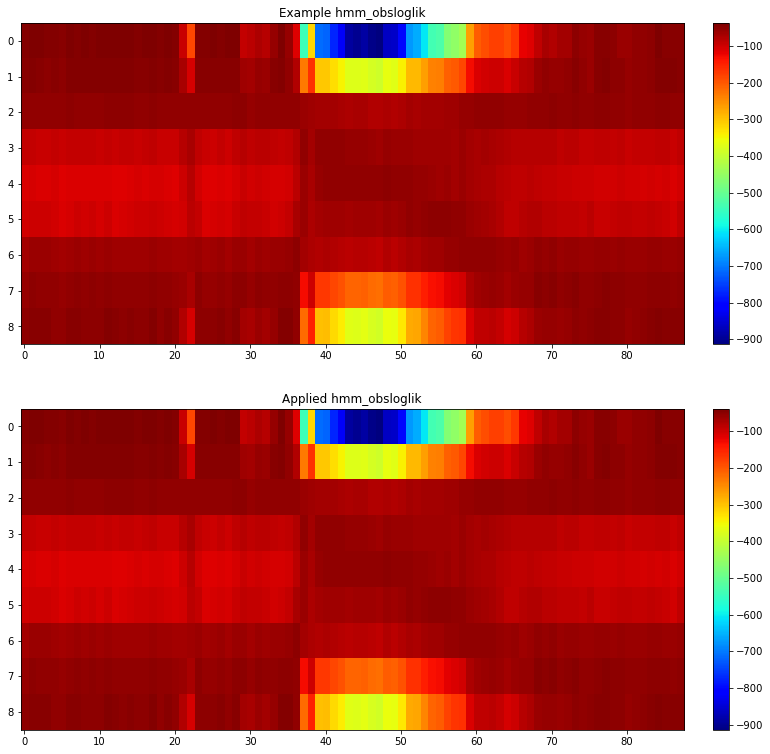

In [9]:
%matplotlib inline

# New figure
plt.figure(figsize=(13,13))

# Generate subplots and show the matrices.
plt.subplot(211)
plt.imshow(example['hmm_obsloglik'].transpose(),interpolation='nearest', aspect='auto', cmap = plt.cm.get_cmap('jet'))
plt.colorbar(fraction=0.046, pad=0.04)

plt.title('Example hmm_obsloglik')
plt.subplot(212)
plt.imshow(hmm_obsloglik.transpose(), interpolation='nearest',aspect='auto', cmap = plt.cm.get_cmap('jet'))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Applied hmm_obsloglik')

Again, the result is the same as in the already implemented likelihood in the example data set. As in the previous example, we can observe high likelihood between silence states and silence windows, and between phonems states and windows with pieces of speech. Consequently, the likelihood decreases considerably between silence states and windows with pieces of speech and viceversa. 

In order to do an extra comparison between the HMM models and the GMM models, we are going to compare the appearence of both models's likelihood for the same digit. In this case, number 7. 

In [10]:
# Log likelihood fot GMM model
gmm_obsloglik_7 = skm.log_multivariate_normal_density(tidigits[17]['mfcc'],models[8]['gmm']['means'],models[8]['gmm']['covars'], 'diag')

# Log likelihoof for HMM model
hmm_obsloglik_7 = skm.log_multivariate_normal_density(tidigits[17]['mfcc'],models[8]['hmm']['means'],models[8]['hmm']['covars'], 'diag')

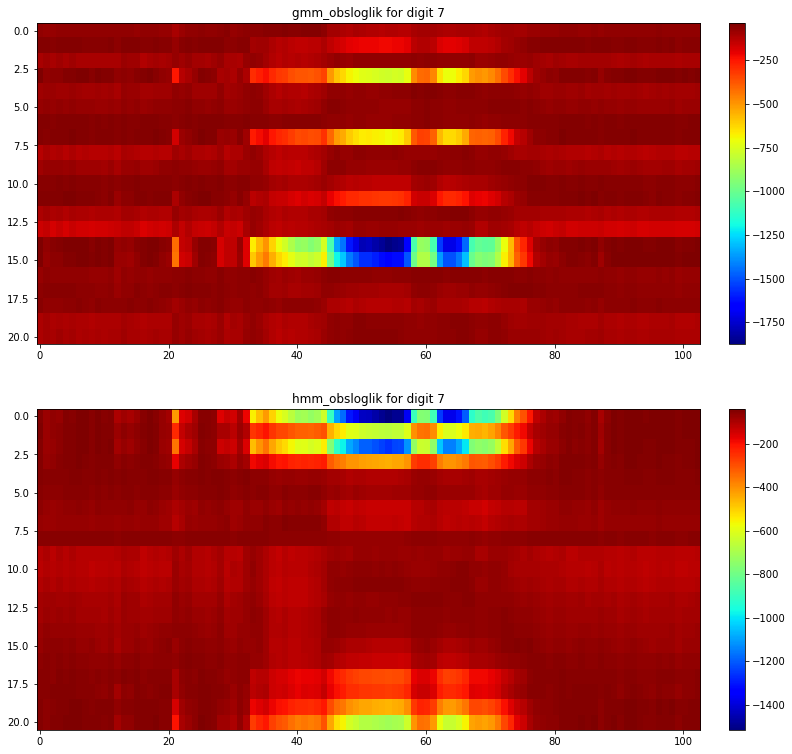

In [11]:
%matplotlib inline

# New figure
plt.figure(figsize=(13,13))

# Generate subplots and show the matrices.
plt.subplot(211)
plt.imshow(gmm_obsloglik_7.transpose(), interpolation='nearest',aspect='auto', cmap = plt.cm.get_cmap('jet'))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('gmm_obsloglik for digit 7')

plt.subplot(212)
plt.imshow(hmm_obsloglik_7.transpose(), interpolation='nearest',aspect='auto', cmap = plt.cm.get_cmap('jet'))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('hmm_obsloglik for digit 7')

We can observe again in the case of the HMM model how the likelihood between non-silent windows and silent states is very low and viceverse. In the case of the GMM now is different, we can see several lines, that corresponds to the separation between the different phonems of the word seven and also the silent parts. Let see if calculating the likelihood for different utterances we can afirm that these lines correspond to the separation between phonems.

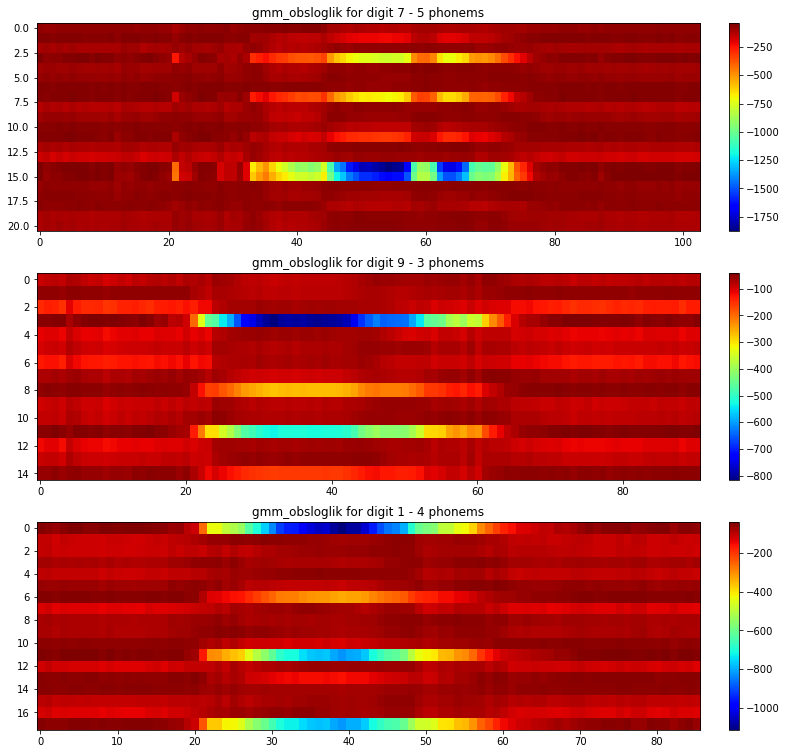

In [12]:
# Log likelihoods

gmm_obsloglik_7 = skm.log_multivariate_normal_density(tidigits[17]['mfcc'],models[8]['gmm']['means'],models[8]['gmm']['covars'], 'diag')
gmm_obsloglik_9 = skm.log_multivariate_normal_density(tidigits[21]['mfcc'],models[10]['gmm']['means'],models[10]['gmm']['covars'], 'diag')
gmm_obsloglik_1 = skm.log_multivariate_normal_density(tidigits[4]['mfcc'],models[2]['gmm']['means'],models[2]['gmm']['covars'], 'diag')


%matplotlib inline

# New figure
plt.figure(figsize=(13,13))

# Generate subplots and show the matrices.
plt.subplot(311)
plt.imshow(gmm_obsloglik_7.transpose(), interpolation='nearest',aspect='auto', cmap = plt.cm.get_cmap('jet'))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('gmm_obsloglik for digit 7 - 5 phonems')

plt.subplot(312)
plt.imshow(gmm_obsloglik_9.transpose(), interpolation='nearest',aspect='auto', cmap = plt.cm.get_cmap('jet'))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('gmm_obsloglik for digit 9 - 3 phonems')

plt.subplot(313)
plt.imshow(gmm_obsloglik_1.transpose(), interpolation='nearest',aspect='auto', cmap = plt.cm.get_cmap('jet'))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('gmm_obsloglik for digit 1 - 4 phonems')



We can observe that, even that the lines of low likelihood are not clear enough to make sure that the number of lines is exactly the number of phonems and silent parts, we conclude that the more phonems we have, the more lines of low likelihood we have.

### 2.4. GMM Likelihood and Recognition


The main objective now is to calculate the log likelihood of an observation sequence X = {x0, . . . , xN−1}
given the full GMM model, that is, given the weights of each Gaussian density in the GMM model. This is, calculate the global likelihood of a series of windows in a utterance. 

Once the function is built, is time to check its performance:

In [13]:
gmmloglik = proto.gmmloglik(gmm_obsloglik, models[0]['gmm']['weights'])
gmmloglik

-4383.9819333143614

In [14]:
example['gmm_loglik']

-4383.9819333143605

We can observe that the output is almost the same, with a error of: 

In [15]:
np.linalg.norm(gmmloglik-example['gmm_loglik'])

9.0949470177292824e-13

#### Uterances scoring

The objective now is to score each of the 44 uterances in the tidigits array with each of the 11 GMM models in models[i]['gmm'] in order to check how many digits are misrecognized. To do so, we have to try each model in each utterance, calculating the likelihoods and storing the maximum likelihood of each utterance. 

In [16]:
## We have to try each model in each utterance, and find the best match. 
dig_class = np.zeros(len(tidigits))
final_dig_GMM = [];

# For each utterances
for i in range(len(tidigits)):
    # We need to store the likelihood dor each model, then.
    model_lik = np.zeros(len(models))
    # For each model
    for j in range(len(models)):
        # Calculate the log normal density for the current model 
        model = skm.log_multivariate_normal_density(tidigits[i]['mfcc'],models[j]['gmm']['means'],
                                                    models[j]['gmm']['covars'], 'diag')
        model_lik[j] = proto.gmmloglik(model, models[j]['gmm']['weights'])
    dig_class[i] = np.argmax(model_lik)

# We want to express this classification in terms of the digits so is easier to identify. 
# First we create a vector with the 11 possible digits
dig = [ 'o', 'z', '1', '2','3','4','5','6','7','8','9']

# We assign each label with each digit
for i in range(len(tidigits)):
    final_dig_GMM.append(dig[int(dig_class[i])])
    
# The last step is to get the actual indeces from tidigits to check if they were well classified
actual_class_GMM = []
for i in range(len(tidigits)):
    actual_class_GMM.append(tidigits[i]['digit'])

We now can check how if any of the utterances were missclassified: 

In [17]:
print(final_dig_GMM,)

['o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']


In [18]:
print(actual_class_GMM,)

['o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']


We can easily see that all of the digits were classified correctly.

### 2.5 HMM likelihood and recognition

The objetive now is to do the same classification as we did with the GMM models. To do so we need to do several steps. 

#### 2.5.1 Forward algorithm

Is time to implement the forward algorithm function. To do so, we have to implement the following formulas: 

$log\alpha_0(j) = log π_j + log \phi_j (x_0)$

$log \alpha_n(j) = log(\sum_{i = 0}^{M-1}e^{log\alpha_{n-1}(i) + log\alpha_{ij}}) +log \phi_j (x_n)$

This does a forward pass calculating the propabilites of each window to be represented by one of the possible states. This equations are implemented in the function forward. We have then to implement this function being the inputs the emissions probabilities (initial probabilities and transition matrices) and the output is the array $log \alpha_{i}(j)$.If we apply this function for the example HMM log multivariate normal distribution and the first digit model, we can check if the function was correctly implemented by comparing its output with the one stored in the dataset example. The distance between this to probability distributions is the one that follows: 

In [19]:
hmm_loga = proto.forward(hmm_obsloglik, np.log(models[0]['hmm']['startprob']), np.log(models[0]['hmm']['transmat']) )
np.linalg.norm(np.nan_to_num(hmm_loga)-np.nan_to_num(example['hmm_logalpha']))

2.1291028635933266e-11

We can see then that the error is small enough. If we show both outputs as images, we have:

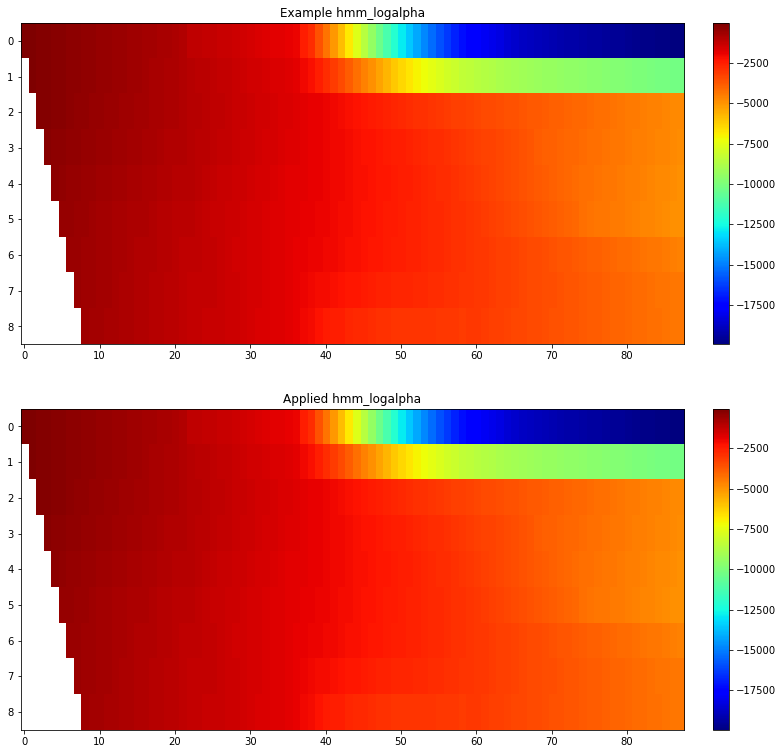

In [20]:
%matplotlib inline

# New figure
plt.figure(figsize=(13,13))

# Generate subplots and show the matrices.
plt.subplot(211)
plt.imshow(example['hmm_logalpha'].transpose(),interpolation='nearest', aspect='auto', cmap = plt.cm.get_cmap('jet'))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Example hmm_logalpha')
plt.subplot(212)
plt.imshow(hmm_loga.transpose(), interpolation='nearest',aspect='auto', cmap = plt.cm.get_cmap('jet'))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Applied hmm_logalpha')

On the first steps, the HMM topology is spreading but keep a strong probability, while in the last steps the probability decreases homogeneously, except in the last two states which probabilities are much lower

The last step os the forward algorithm is to convert the probability distribution to the log domain and add all the probabilities of each frame. To do so, we use the logsumexp function with only the last row as we can marginalize out the last frame of the utterance. This means, that the total likelihood of the whole uterance, only depends on the last frame of the utterance. This is easy to see in previous figure, as we see that the maximum likelihoods are given for the last windows. 

In [21]:
# Likelihood of the whole secuence
hmm_loglik = tools2.logsumexp( hmm_loga[len(hmm_loga)-1, :] )
hmm_loglik

-4362.8683281722906

In [22]:
example['hmm_loglik']

-4362.8683281722906

If we compare both the stored value in the example data and the calculated value are apparently the same being the distance between them suffiently small:

In [23]:
np.linalg.norm(hmm_loglik-example['hmm_loglik'])

0.0

#### Uterances scoring

The objective now is to score each of the 44 uterances in the tidigits array with each of the 11 HMM models in models[i]['hmm'] in order to check how many digits are misrecognized. To do so, we have to try each model in each utterance, calculating the likelihoods and storing the maximum likelihood of each utterance. 

In [24]:
## We have to try each model in each utterance, and find the best match. 
dig_class = np.zeros(len(tidigits))
final_dig_HMM = [];

# For each utterances
for i in range(len(tidigits)):
    # We need to store the likelihood dor each model, then.
    loga_model = np.zeros(len(models))
    # For each model
    for j in range(len(models)):
        # Calculate the log normal density for the current model 
        model = skm.log_multivariate_normal_density(tidigits[i]['mfcc'],models[j]['hmm']['means'],
                                                    models[j]['hmm']['covars'], 'diag')
        # Apply the forward pass
        loga = proto.forward(model, np.log(models[j]['hmm']['startprob']), np.log(models[j]['hmm']['transmat']) )
        # Likelihood of the whole secuence
        loga_model[j] = tools2.logsumexp(loga[len(loga)-1, :] )
    dig_class[i] = np.argmax(loga_model)

# We want to express this classification in terms of the digits so is easier to identify. 
# First we create a vector with the 11 possible digits
dig = [ 'o', 'z', '1', '2','3','4','5','6','7','8','9']

# We assign each label with each digit
for i in range(len(tidigits)):
    final_dig_HMM.append(dig[int(dig_class[i])])
    
# The last step is to get the actual indeces from tidigits to check if they were well classified
actual_class_HMM = []
for i in range(len(tidigits)):
    actual_class_HMM.append(tidigits[i]['digit'])

We now can check how if any of the utterances were missclassified: 

In [25]:
print(final_dig_HMM,)

['o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '5', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '3', '8', '9', '9']


In [26]:
print(actual_class_HMM,)

['o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']


We can see some differences, lets check how many utterances were missclassified:

In [27]:
count = 0;
for i in range(len(final_dig_HMM)):
    if final_dig_HMM[i] != actual_class_HMM[i]:
        count = count + 1;
count

2

We have only 2 missclassified utterances: second repetition of the digit 9 for the male speaker with a 5, and the first repetition of the digit 8 of the female speker with a 3

#### HMM recognition using the Gaussian distribution in the HMM models.

Now we want to repeat the recognition using the Gaussian distributions in the HMM models as if they were
a GMM model with equal weights for each Gaussian. The process is exactly the same as we did for the GMM models using in this case the Gaussian distribution of the HMM models.  To do so, we have to try each model in each utterance, calculating the likelihoods and storing the maximum likelihood of each utterance. The only difference is that now the weights are initizalized with the same normalized value. 

In [28]:
## We have to try each model in each utterance, and find the best match. 
dig_class = np.zeros(len(tidigits))
final_dig_GHMM = [];

# For each utterances
for i in range(len(tidigits)):
    # We need to store the likelihood dor each model, then.
    model_lik = np.zeros(len(models))
    # For each model
    for j in range(len(models)):
        # Calculate the log normal density for the current model 
        model = skm.log_multivariate_normal_density(tidigits[i]['mfcc'],models[j]['hmm']['means'],
                                                    models[j]['hmm']['covars'], 'diag')
        A,B = model.shape
        weights = np.ones(B,)*(1./B)
        model_lik[j] = proto.gmmloglik(model, weights)
    dig_class[i] = np.argmax(model_lik)

# We want to express this classification in terms of the digits so is easier to identify. 
# First we create a vector with the 11 possible digits
dig = [ 'o', 'z', '1', '2','3','4','5','6','7','8','9']

# We assign each label with each digit
for i in range(len(tidigits)):
    final_dig_GHMM.append(dig[int(dig_class[i])])
    
# The last step is to get the actual indeces from tidigits to check if they were well classified
actual_class_GHMM = []
for i in range(len(tidigits)):
    actual_class_GHMM.append(tidigits[i]['digit'])

In [29]:
print(final_dig_GHMM,)

['o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']


In [30]:
print(actual_class_GHMM,)

['o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']


In this case we can see that all the utterances were correctly classified. The main reason why using the Gaussian distribution of the HMM classifies better than the Forward pass is due to the influence of the transition model. This HMM transition model determines what has the most chances of happenning given the current state, calculating the total likelihood of the last window after the forward propagation over the windows, while using the Gaussian distribution, it uses all the windows probabilities of a utterance to calculate the total likelihood

### 2.6. Viterbi Aproximation

In this section the Viterbi aprroximation will be implemented and applied. The viterbi approximation if the log likelihood of the observation X given a HMM model and the best sequence of states. The recursion formulas, similar to the forward algorithm ones, are: 

$logV_0(j) = log π_j + log \phi_j (x_0)$

$logV_n(j) = \max_{i = 0}^{M-1}({logV_{n-1}(i) + log\alpha_{ij}}) +log \phi_j (x_n)$

In order to recover the best path, we will also need an array storing the best previous pathfor each time step and state (this needs to be defined only for n ∈ [1, N), that is not for the first time step):

$B_n(j) = argmax_{i = 0}^{M-1}({logV_{n-1}(i) + log\alpha_{ij}})$

The implementation of this algorithm is explained in the bibliography of the course


In [31]:
vit_loglik,vit_path = proto.viterbi(hmm_obsloglik, np.log(models[0]['hmm']['startprob']), np.log(models[0]['hmm']['transmat']))

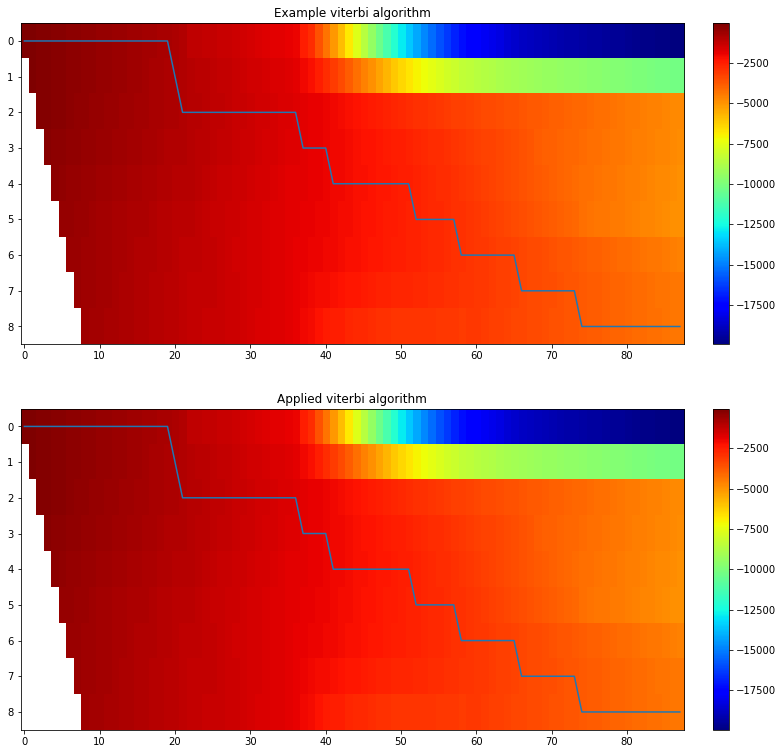

In [32]:
%matplotlib inline

# New figure
plt.figure(figsize=(13,13))

# Generate subplots and show the matrices.
plt.subplot(211)
plt.imshow(example['hmm_logalpha'].transpose(),interpolation='nearest', aspect='auto', cmap = plt.cm.get_cmap('jet'))
plt.plot(example['hmm_vloglik'][1])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Example viterbi algorithm')
plt.subplot(212)
plt.imshow(hmm_loga.transpose(), interpolation='nearest',aspect='auto', cmap = plt.cm.get_cmap('jet'))
plt.plot(vit_path)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Applied viterbi algorithm')

The main difference between this algorithm and the forward algorithm is that while in the forward algorithm, the final likelihood is given by the logsumexp of all the log probabilities of the last window of the utterance, in the viterbi, the algorithm follows the path with maximum probability along the windows and the final likelihood is given by the maximum log probability of all the windows. How ever, both are based in HMM models, that is way the path evolves slowly, as the highest probability is of a state to remain in the same state.

This can be shown in the next figure, as we can observe how, computing the max value of every window in the alpha array, we get almost the same path:

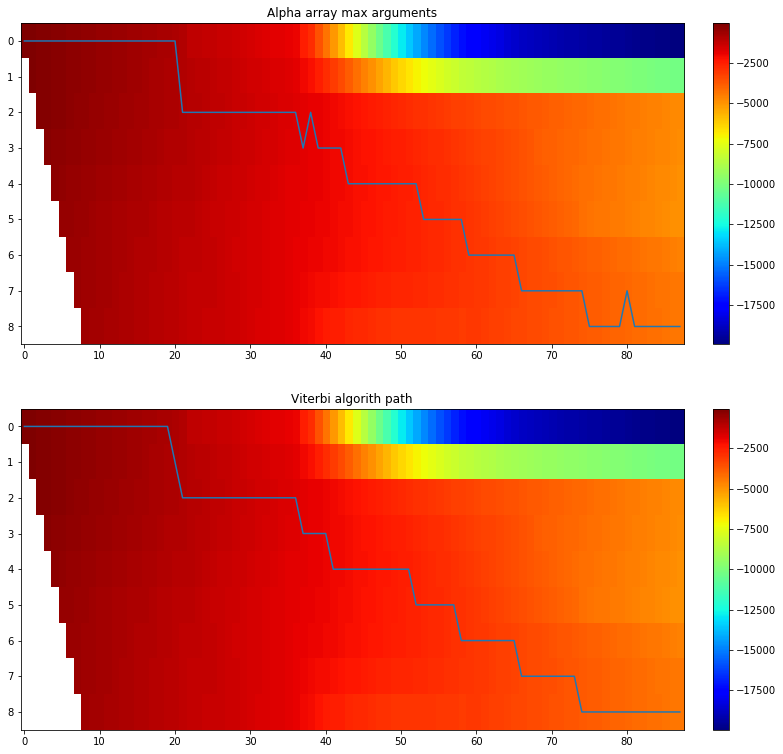

In [33]:
max_val = np.zeros(len(hmm_loga))
for i in range(len(hmm_loga)):
    max_val[i] = np.argmax(hmm_loga[i,:])

%matplotlib inline

# New figure
plt.figure(figsize=(13,13))

plt.subplot(211)
plt.imshow(hmm_loga.transpose(), interpolation='nearest',aspect='auto', cmap = plt.cm.get_cmap('jet'))
plt.plot(max_val)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Alpha array max arguments')
plt.subplot(212)
plt.imshow(hmm_loga.transpose(), interpolation='nearest',aspect='auto', cmap = plt.cm.get_cmap('jet'))
plt.plot(vit_path)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Viterbi algorith path')

#### Utterances scoring

The objetive now is to use the Viterbi algorithm to score all the 44 utterances in tidigits with each of the 11
HMM models in models and see how many mistakes can be counted if we take the maximum likelihood model as winner. To do so, we have to try each model in each utterance, calculating the likelihoods and storing the maximum likelihood of each utterance.

In [34]:
## We have to try each model in each utterance, and find the best match. 
dig_class = np.zeros(len(tidigits))
final_dig_Vit = [];

# For each utterances
for i in range(len(tidigits)):
    # We need to store the likelihood dor each model, then.
    model_lik = np.zeros(len(models))
    # For each model
    for j in range(len(models)):
        # Calculate the log normal density for the current model 
        model = skm.log_multivariate_normal_density(tidigits[i]['mfcc'],models[j]['hmm']['means'],
                                                    models[j]['hmm']['covars'], 'diag')
        model_lik[j],numb = proto.viterbi(model, np.log(models[j]['hmm']['startprob']), np.log(models[j]['hmm']['transmat']))
    dig_class[i] = np.argmax(model_lik)

# We want to express this classification in terms of the digits so is easier to identify. 
# First we create a vector with the 11 possible digits
dig = [ 'o', 'z', '1', '2','3','4','5','6','7','8','9']

# We assign each label with each digit
for i in range(len(tidigits)):
    final_dig_Vit.append(dig[int(dig_class[i])])
    
# The last step is to get the actual indeces from tidigits to check if they were well classified
actual_class_Vit = []
for i in range(len(tidigits)):
    actual_class_Vit.append(tidigits[i]['digit'])

In [35]:
print(final_dig_Vit,)

['o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '5', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '3', '8', '9', '9']


In [36]:
print(actual_class_Vit,)

['o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']


We can see some differences, lets see how many utterances where missclassified

In [37]:
count = 0;
for i in range(len(final_dig_Vit)):
    if final_dig_Vit[i] != actual_class_Vit[i]:
        count = count + 1;
count

2

As in the case of the HMM classification, we have only 2 missclassified utterances: second repetition of the digit 9 for the male speaker with a 5, and the first repetition of the digit 8 of the female speaker with a 3. Therefor, we can conclude that the Viterbi algorithm does not improve the HMM classification enough, as we get the exact same missclassifications in both options. 

### 2.7. Backward pass

Is time to implement the forward algorithm function. To do so, we have to implement the following formulas:

$log \beta_{N-1}(i) = 0$

$log \beta_{n}(i) = log(\sum_{j = 0}^{M-1}e^{log\beta_{n+1}(j) + log\alpha_{ij} +log \phi_j (x_{n+1})})$

This does a backward pass calculating the propabilites of each window to be represented by one of the possible states. This equations are implemented in the function backward. We have then to implement this function being the inputs the emissions probabilities (initial probabilities and transition matrices) as in the previous section and the output is the array $log \beta_{j}(i)$.  If we apply this function for the example HMM log multivariate normal distribution and the first digit model, we can check if the function was correctly implemented by comparing its output with the one stored in the dataset example. The distance between this two probability distributions is the one that follows:

In [38]:
hmm_back = proto.backward(hmm_obsloglik, np.log(models[0]['hmm']['startprob']), np.log(models[0]['hmm']['transmat']) )
np.linalg.norm(np.nan_to_num(hmm_back)-np.nan_to_num(example['hmm_logbeta']))

1.370714103954586e-11

We can see that the error is small enough. If we plot, both the calculated likelihood and the one stored in example we get

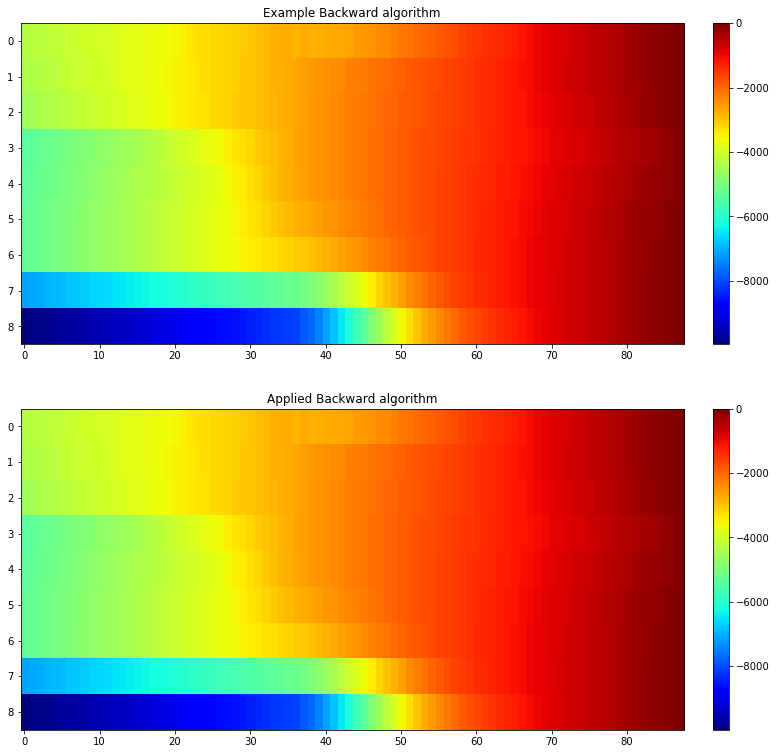

In [39]:
%matplotlib inline

# New figure
plt.figure(figsize=(13,13))

# Generate subplots and show the matrices.
plt.subplot(211)
plt.imshow(example['hmm_logbeta'].transpose(),interpolation='nearest', aspect='auto', cmap = plt.cm.get_cmap('jet'))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Example Backward algorithm')
plt.subplot(212)
plt.imshow(hmm_back.transpose(), interpolation='nearest',aspect='auto', cmap = plt.cm.get_cmap('jet'))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Applied Backward algorithm')

As now the algorithm moves backwards, from the last window to the first one of the utterances the highest probabilities are in the last windows, decreasing as we move towards the first windows, being the lowest probabilities at the last states of the first window. This make sense, as the probability of being in the last states in the first windows is very low, as they represent the last part of the utterance. 

#### Utterances Scoring

The objetive now is to use the Viterbi algorithm to score all the 44 utterances in tidigits with each of the 11 HMM models in models and see how many mistakes can be counted if we take the maximum likelihood model as winner. To do so, we have to try each model in each utterance, calculating the likelihoods and storing the maximum likelihood of each utterance.

In [40]:
## We have to try each model in each utterance, and find the best match. 
dig_class = np.zeros(len(tidigits))
final_dig_Back = [];

# For each utterances
for i in range(len(tidigits)):
    # We need to store the likelihood dor each model, then.
    loga_model = np.zeros(len(models))
    # For each model
    for j in range(len(models)):
        # Calculate the log normal density for the current model 
        model = skm.log_multivariate_normal_density(tidigits[i]['mfcc'],models[j]['hmm']['means'],
                                                    models[j]['hmm']['covars'], 'diag')
        # Apply the forward pass
        loga = proto.backward(model, np.log(models[j]['hmm']['startprob']), np.log(models[j]['hmm']['transmat']) )
        # Likelihood of the whole secuence
        loga_model[j] = tools2.logsumexp(loga[0, :] )
    dig_class[i] = np.argmax(loga_model)

# We want to express this classification in terms of the digits so is easier to identify. 
# First we create a vector with the 11 possible digits
dig = [ 'o', 'z', '1', '2','3','4','5','6','7','8','9']

# We assign each label with each digit
for i in range(len(tidigits)):
    final_dig_Back.append(dig[int(dig_class[i])])
    
# The last step is to get the actual indeces from tidigits to check if they were well classified
actual_class_Back = []
for i in range(len(tidigits)):
    actual_class_Back.append(tidigits[i]['digit'])

In [41]:
print(final_dig_Back,)

['o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '5', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '3', '8', '9', '9']


In [42]:
print(actual_class_Back,)

['o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']


We can see some differences, lets see how many miss classified utterances are there

In [43]:
count = 0;
for i in range(len(final_dig_Back)):
    if final_dig_Back[i] != actual_class_Back[i]:
        count = count + 1;
count

2

As expected, we have the same number of missclassified utterances as in the case of the HMM classification, we have only 2 missclassified utterances: second repetition of the digit 9 for the male speaker with a 5, and the first repetition of the digit 8 of the female speaker with a 3. This is because, both algorithms are based in the HMM models transition matrix and initial probabilities, therefore, the states evolution will be the same, even if we analyze the frames forward or backwards. 

## 3. Final comparison

The final step is to compare the performance of the difference algorithms and techniques that were presented in this lab. To do so, we are going to plot the missclassifications of each method as an image.



In [44]:
final_plot = np.zeros((5,len(final_dig_Back)))
for i in range(len(final_dig_Back)):
    # GMM algorithm
    if final_dig_GMM[i] != actual_class_GMM[i]:
        final_plot[0,i] = final_dig_GMM[i];
    else:
        final_plot[0,i] = 0;
        
        # Forward algorithm
    if final_dig_HMM[i] != actual_class_HMM[i]:
        final_plot[1,i] = final_dig_HMM[i];
    else:
        final_plot[1,i] = 0;
        
        # Gaussian HMM algorithm
    if final_dig_GHMM[i] != actual_class_GHMM[i]:
        final_plot[2,i] = final_dig_GHMM[i];
    else:
        final_plot[2,i] = 0;
        
        # Vit algorithm
    if final_dig_Vit[i] != actual_class_Vit[i]:
        final_plot[3,i] = final_dig_Vit[i];
    else:
        final_plot[3,i] = 0;
        
        # Back algorithm
    if final_dig_Back[i] != actual_class_Back[i]:
        final_plot[4,i] = final_dig_Back[i];
    else:
        final_plot[4,i] = 0;

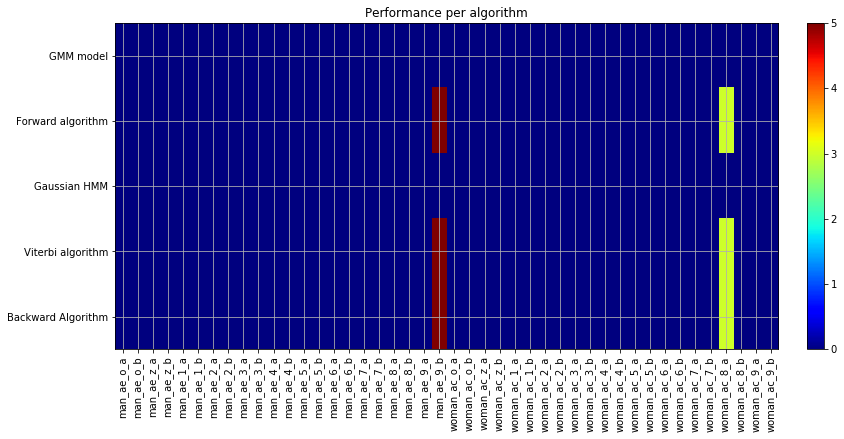

In [45]:
# Create the labels for the figure
xlabels = tools2.tidigit2labels(tidigits)
ylabels = ['GMM model','Forward algorithm','Gaussian HMM','Viterbi algorithm', 'Backward Algorithm']
%matplotlib inline

# New figure
fig = plt.figure(figsize=(13,6))

ax = fig.gca()
plt.xticks(np.arange(0, len(actual_class_Back), 1), xlabels, rotation='vertical')
plt.yticks(np.arange(0, 5, 1), ylabels, rotation='horizontal')

# Generate subplots and show the matrices.
plt.imshow(final_plot ,interpolation='nearest', aspect='auto', cmap = plt.cm.get_cmap('jet'))
plt.colorbar(fraction=0.046, pad=0.04)
plt.grid()
plt.title('Performance per algorithm')

We can see the the algorithms based in the Gaussian distribution classify the utterances perfectly (both using the GMM classification and the HMM classification using the Gaussian distribution of the GMM and HMM models respectively). However, when we use the state transition model, or Hidden Markov Model, with any of the proposed algorithms that use the initial probability and transition matrix to calculate the likelihood, some utterances (the same in all cases) are missclassified. Not even applying the viterbi algorithm (that can be understood as an improvement of the forward algorithm) we are able to classify all the utterances correctly. 